In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_winter.yaml'

In [7]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

# ## Get ocean mask 
# lm = gr.get_landmask()
# ocean = lm.Landmask == 0
# ocean = ocean.values[:,:,np.newaxis]

# ## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = False)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_II_Winter_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_II_Winter_SAM_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.79 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 11.72 seconds


## density

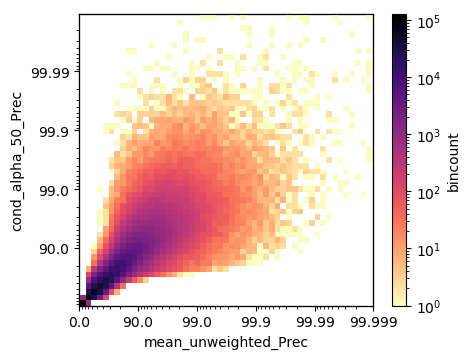

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.7))
jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = ax)
plt.tight_layout()

## mcs bin fraction

(<AxesSubplot:xlabel='mean_unweighted_Prec', ylabel='cond_alpha_50_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x14c36213b8b0>)

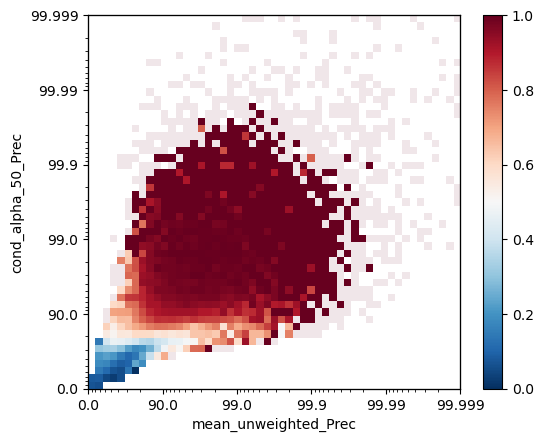

In [9]:
%matplotlib inline
data, noise, count = jd.get_mcs_bin_fraction(region_mask = None, bin_noise_treshold= 4)
jd.plot_data(data, noise, vbds = (0,1))

## normalized density

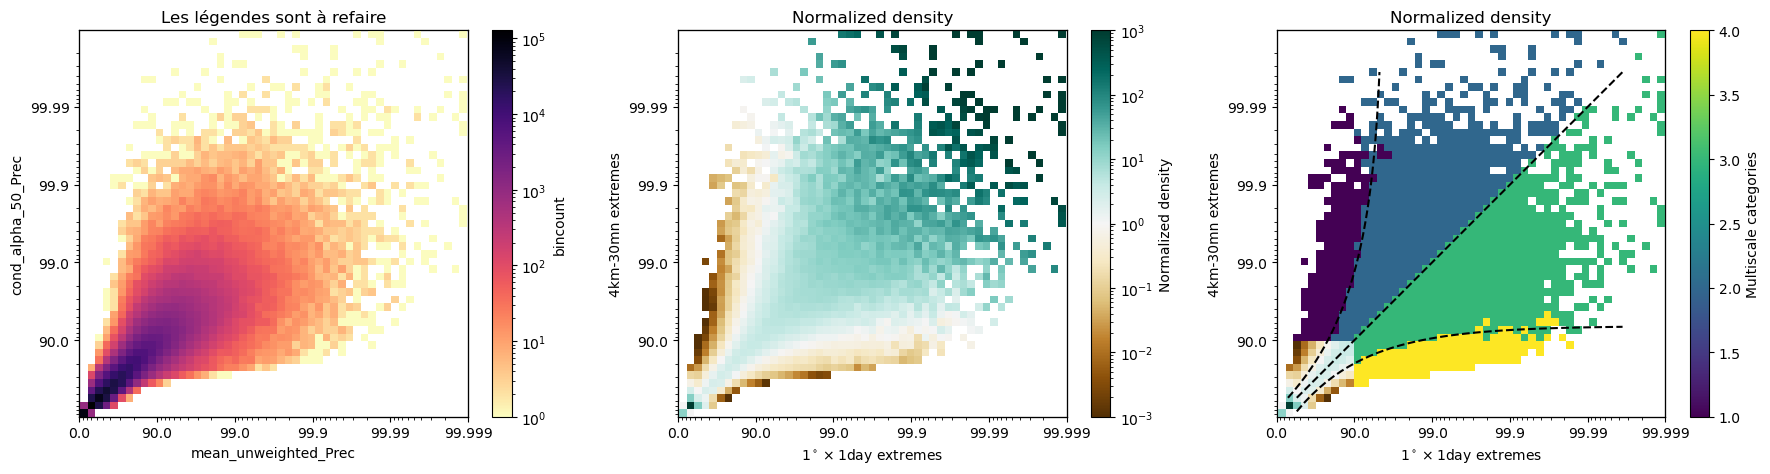

In [11]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

Convective only
figure size = 15 3.25
Mostly convective
figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


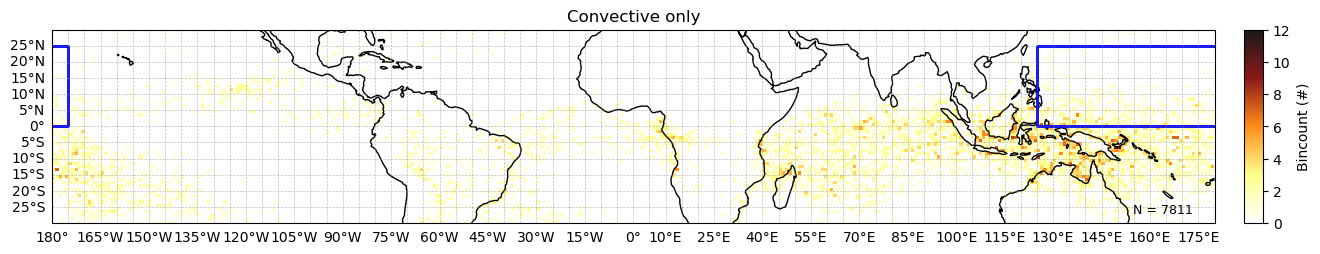

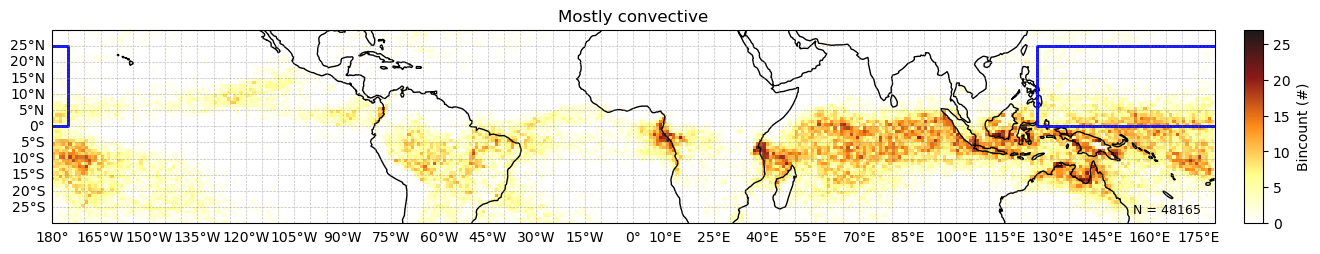

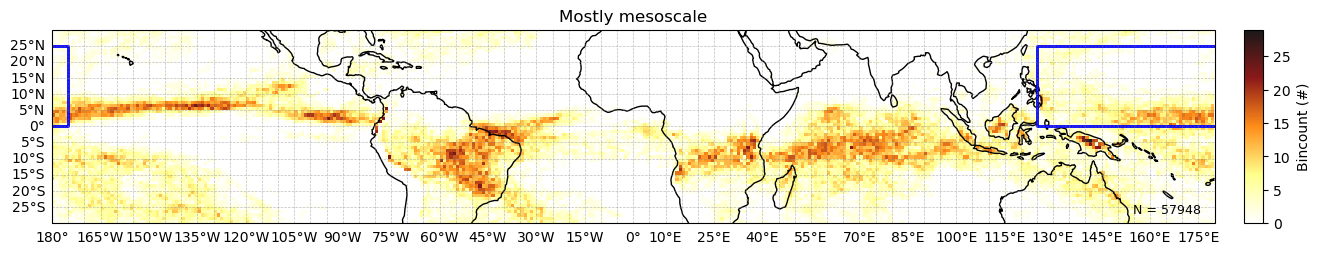

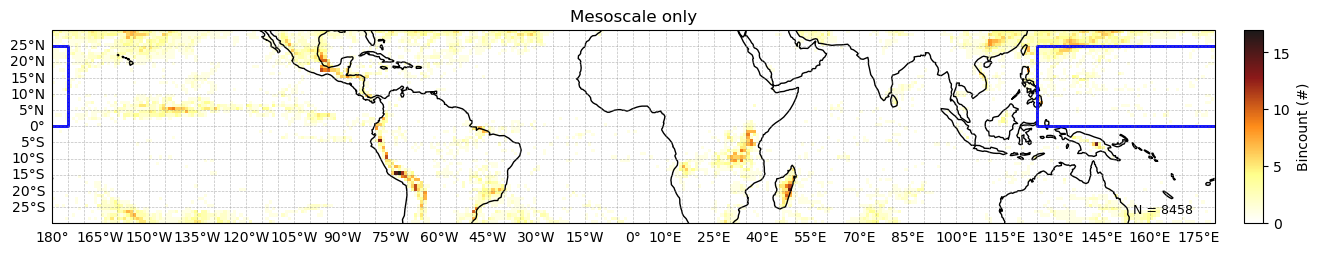

In [12]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 90
rank_acc_min = 90

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    # mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 125, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## MCS everyday so no prob

In [29]:
def count_unique_non_nan_per_slice(arr, axis=2):
    unique_counts = np.zeros(arr.shape[axis], dtype=int)
    
    # Iterate over each slice along the specified axis
    for i in range(arr.shape[axis]):
        # Extract the slice, ignoring NaN values
        slice = arr.take(indices=i, axis=axis)
        non_nan_slice = slice[~np.isnan(slice)]
        
        # Count the unique elements in the slice
        unique_elements = np.unique(non_nan_slice)
        unique_counts[i] = len(unique_elements)
    
    return unique_counts

out = count_unique_non_nan_per_slice(jd.labels_regridded_yxtm)

In [31]:
out

array([2577, 3836, 4017, 4029, 4090, 3949, 4237, 4651, 4674, 4724, 4938,
       5226, 5265, 5072, 4750, 4410, 4407, 4323, 4391, 3973, 4378, 4840,
       4949, 4736, 4542, 4580, 4885, 4979, 4819, 4314, 4484, 4465, 4766,
       4761, 4889, 4873, 5090, 5338, 5062, 4875])